# Project: Guess a Celebrity

## 1. Problem Statement

You and your team are working on improving your facial recognition service. Your company has received a request to use the service you developed at an IT conference where these famous people will be speaking.

To do this, we will train a five-class classifier using the full power of pre-trained networks.

**Project goals:**
* Solving a multi-class classification problem;
* Using the principle of transfer learning;
* Visualization of data and the model's predictions.

And your main goal is to achieve **accuracy > 0.85** on the validation set.

## 2. Import Libraries and Define Constants

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

import torch
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder

BATCH_SIZE = 64
EPOCHS = 3

# Check if Apple MPS is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device


device(type='mps')

## 3. Load Data and Prepare Data

Identify the number of images in the training dataset.

In [2]:
!find data/train/ -type f | wc -l

    3001


The training dataset contains 3000 images. Which is not much compared to the number of images in the Imagemodel dataset used to train the pre-trained models.

The scenario can be classified as a small dataset mainly different to what the base modelwork to be used was trained on (since Imagemodel is restricting human images).

I will use the following pattern:
1. Remove the last layer of the fully connected network and several CNN layers at the end of the modelwork.
2. Add a new fully connected layer with an output size equal to the number of classes in the new dataset.
3. Freeze all weights from the remaining pre-trained CNN.
4. Update the weights of the new fully connected layer during training.

In [3]:
!find data/valid/ -type f | wc -l

     914


The validation dataset contains 914 images. That constitutes around 23 % of the whole dataset, which is a good ratio.

Loading train and validation datasets using the class `ImageFolder` from the `TorchVision` library.

In [4]:
train_dataset = ImageFolder("data/train/")
valid_dataset = ImageFolder("data/valid/")

# Output one sample from the training dataset
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=70x70>, 0)

The image has the class `PIL.Image` and also there is a class label of the sample. Let's take a look at the class name and the image itself.

bill_gates


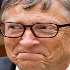

In [5]:
print(train_dataset.classes[train_dataset[0][1]])
train_dataset[0][0]

The label `0` corresponds to the class `bill_gates` and the image is a picture of Bill Gates.

Let's define a function which will render random images from a dataset.

In [6]:
def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title(random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()

Now I will render five random images.

Train dataset:


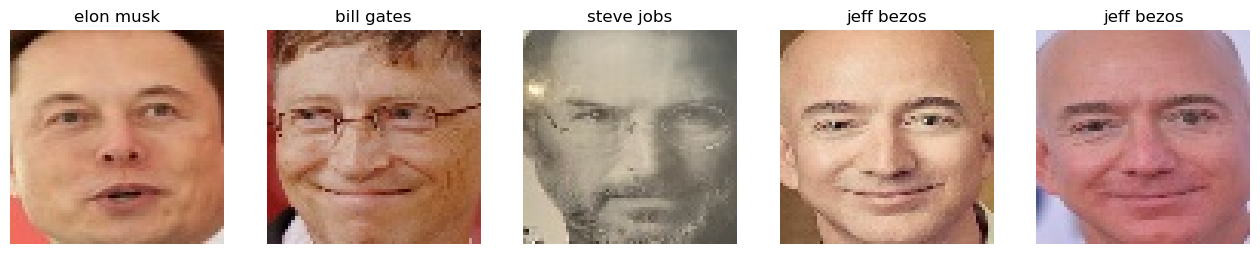

Validation dataset


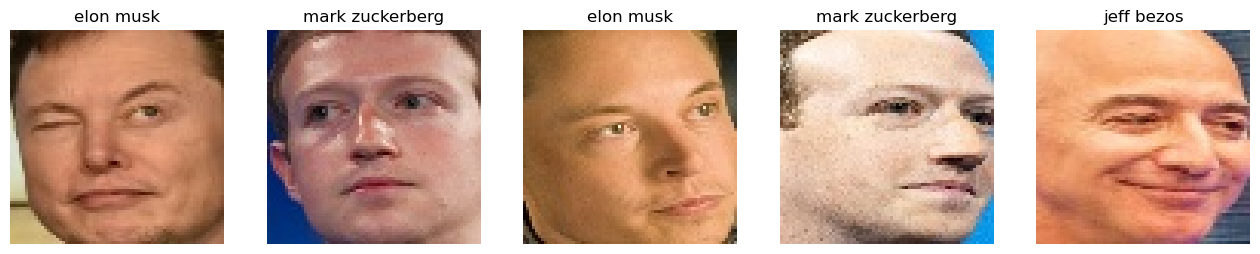

In [7]:
print('Train dataset:')
plot_samples(train_dataset)

print('Validation dataset')
plot_samples(valid_dataset)

To use these datasets in the training process, we apply standard ResNet-style preprocessing to them.

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
valid_dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

Getting the data loaders ready.

In [9]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()
)

## 4. Training the Model

I will use this generic function to train the models for all different types of model architecture I want to experiment with.

In [10]:
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10):
    loss_train = []
    top1_train = []
    loss_valid = []
    top1_valid = []

    for epoch in range(num_epochs):
        torch.set_grad_enabled(True)
        model.train()

        losses = []
        equals = []

        for images, target in tqdm(train_loader):
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)

            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(np.mean(losses))
        top1_train.append(np.mean(equals))

        torch.set_grad_enabled(False)
        model.eval()

        losses = []
        equals = []

        for images, target in tqdm(valid_loader):
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)

            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

        loss_valid.append(np.mean(losses))
        top1_valid.append(np.mean(equals))

    return loss_train, top1_train, loss_valid, top1_valid

The following function will be used to visually render the training results.

In [11]:
def render_results(loss_train, top1_train, loss_valid, top1_valid):
    plt.figure(figsize=(14, 6))

    plt.subplot(121)
    plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
    plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
    plt.xlabel("Номер эпохи")
    plt.title("Функция потери")

    plt.subplot(122)
    plt.plot(range(1, len(loss_train) + 1), top1_train, color="b")
    plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r")
    plt.xlabel("Номер эпохи")
    plt.title("Точность")

    plt.show()

The following function will be used to set-up and train a model.

In [16]:
def set_up_and_train(model, train_loader, valid_loader):
    # Freeze the weights of all other layers and train only the final dense layer.
    for parameter in model.parameters():
        parameter.requires_grad = False
    for parameter in model.fc.parameters():
        parameter.requires_grad = True

    # Use Cross Entropy Loss for multi-class classification
    criterion = torch.nn.CrossEntropyLoss()

    # Move the model and criterion to the selected device (MPS/CPU)
    model = model.to(device)
    criterion = criterion.to(device)

    # Use Adam optimizer with weight decay (L2 regularization)
    # It is important to create it after the model is moved to the device
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

    # Train the model
    loss_train, top1_train, loss_valid, top1_valid = train_model(model, criterion, optimizer, train_loader, valid_loader, EPOCHS)

    print('Maximum validation accuracy: ', max(top1_valid))
    render_results(loss_train, top1_train, loss_valid, top1_valid)

For training, I will take the lightweight ResNet-34 model from the ResNet family.

In [ ]:
model_dense = models.resnet34(pretrained=True)
model_dense

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 4.1 Replacing the Dense Layer

To apply transfer learning strategy to the pre-trained ResNet-34 model, I will start with replaicing the ultimate dense layer `fc` to match the number of classes in this task - 5.

Then set-up and train the model.

100%|██████████| 15/15 [00:55<00:00,  3.67s/it]

Maximum validation accuracy:  0.7899343544857768


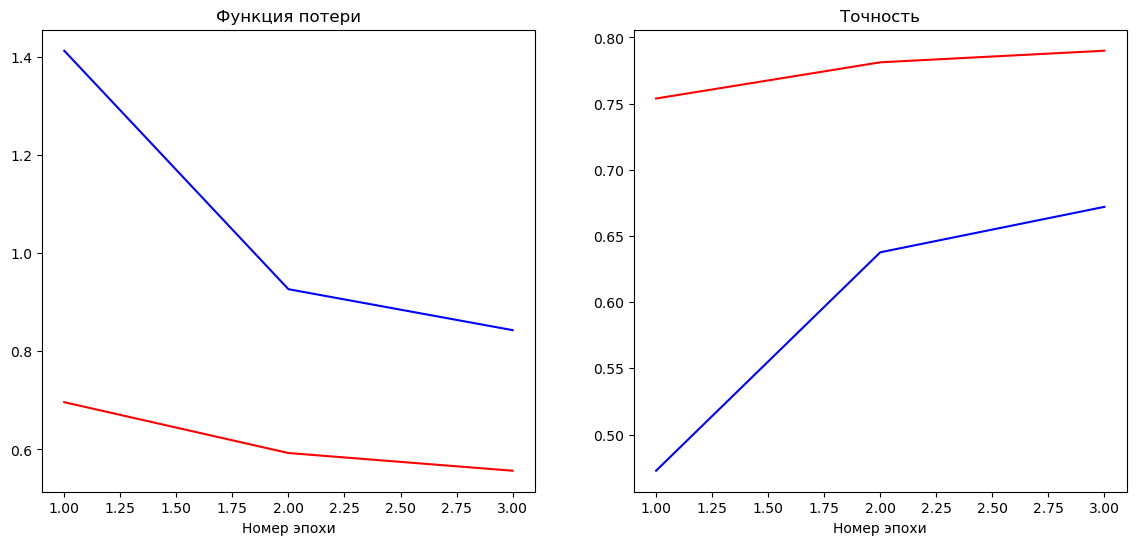

In [ ]:
model_dense.fc = torch.nn.Linear(512, len(train_dataset.classes))

set_up_and_train(model_dense, train_loader, valid_loader)

# # Freeze the weights of all other layers and train only the final dense layer.
# for parameter in model_dense.parameters():
#     parameter.requires_grad = False
# for parameter in model_dense.fc.parameters():
#     parameter.requires_grad = True

# # Use Cross Entropy Loss for multi-class classification
# criterion = torch.nn.CrossEntropyLoss()

# # Move the model and criterion to the selected device (MPS/CPU)
# model_dense = model_dense.to(device)
# criterion = criterion.to(device)

# # Use Adam optimizer with weight decay (L2 regularization)
# # It is important to create it after the model is moved to the device
# optimizer = torch.optim.Adam(model_dense.parameters(), lr=1e-2, weight_decay=1e-4)

# # Train the model
# loss_train, top1_train, loss_valid, top1_valid = train_model(model_dense, criterion, optimizer, train_loader, valid_loader, EPOCHS)

# print('Maximum validation accuracy: ', max(top1_valid))
# render_results(loss_train, top1_train, loss_valid, top1_valid)

### 4.2 Replacing the Dense Layer and the Last CNN Layer

To apply a second transfer learning strategy to the pre-trained ResNet-34 model, I will:
* Delete the last CNN Layer: `layer4`, `BasicBlock (2)`.
* Replaice the ultimate dense layer `fc` to match the number of classes in this task - 5.

In [14]:
model_cnn1_dense = models.resnet34(pretrained=True)
model_cnn1_dense.layer4 = torch.nn.Sequential(model_cnn1_dense.layer4[:2])
model_cnn1_dense.fc = torch.nn.Linear(512, len(train_dataset.classes))
model_cnn1_dense

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Then set-up and train the model.

100%|██████████| 15/15 [00:55<00:00,  3.73s/it]

Maximum validation accuracy:  0.8347921225382933


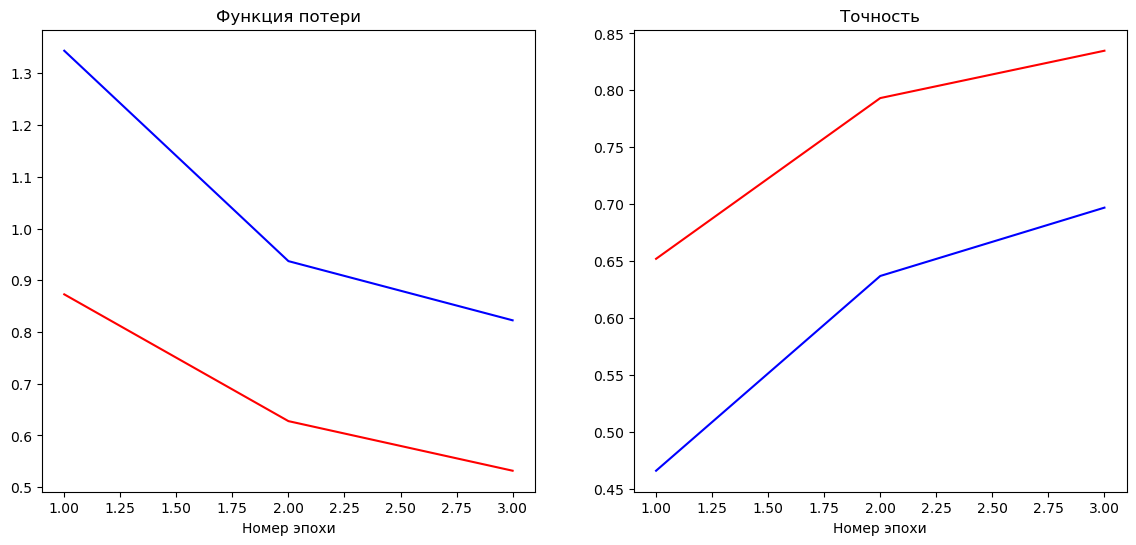

In [ ]:
set_up_and_train(model_cnn1_dense, train_loader, valid_loader)


# # Freeze the weights of all other layers and train only the final dense layer.
# for parameter in model_cnn1_dense.parameters():
#     parameter.requires_grad = False
# for parameter in model_cnn1_dense.fc.parameters():
#     parameter.requires_grad = True

# # Use Cross Entropy Loss for multi-class classification
# criterion = torch.nn.CrossEntropyLoss()

# # Move the model and criterion to the selected device (MPS/CPU)
# model_cnn1_dense = model_cnn1_dense.to(device)
# criterion = criterion.to(device)

# # Use Adam optimizer with weight decay (L2 regularization)
# # It is important to create it after the model is moved to the device
# optimizer = torch.optim.Adam(model_cnn1_dense.parameters(), lr=1e-2, weight_decay=1e-4)

# # Train the model
# loss_train, top1_train, loss_valid, top1_valid = train_model(model_cnn1_dense, criterion, optimizer, train_loader, valid_loader, EPOCHS)

# print('Maximum validation accuracy: ', max(top1_valid))
# render_results(loss_train, top1_train, loss_valid, top1_valid)

### 4.3 Replacing the Dense Layer and the Last Two CNN Layers

To apply a third transfer learning strategy to the pre-trained ResNet-34 model, I will:
* Delete the last two CNN Layers: `layer4`, `BasicBlock (1) and (2)`.
* Replaice the ultimate dense layer `fc` to match the number of classes in this task - 5.

In [ ]:
model_cnn2_dense = models.resnet34(pretrained=True)
model_cnn2_dense.layer4 = torch.nn.Sequential(model_cnn2_dense.layer4[:1])
model_cnn2_dense.fc = torch.nn.Linear(512, len(train_dataset.classes))
model_cnn2_dense

Then set-up and train the model.

In [ ]:
set_up_and_train(model_cnn2_dense, train_loader, valid_loader)